# Lezione 12

In [ ]:
from liblet import (
  Grammar, 
  Derivation,
  Production,
  ProductionGraph, 
  TopDownInstantaneousDescription,
  Table, 
  closure,
  suffixes,
  warn,
  HASH, ε
)

In [ ]:
def compute_εfirst(G):
  FIRST = Table(1, element = set)
  for t in G.T: FIRST[(t, )] = {t}
  FIRST[tuple()] = {ε}
  FIRST[(ε, )] = {ε}
  FIRST[(HASH, )] = {HASH}
  @closure
  def update_with_suffixes(FIRST):
    for N, α in G.P:
      FIRST[(N, )] |= FIRST[α]
      for γ in suffixes(α):
        A, *β = γ
        FIRST[γ] |= FIRST[(A, )] - {ε}
        if ε in FIRST[(A, )]: FIRST[γ] |= FIRST[β]
    return FIRST
  return update_with_suffixes(FIRST)

def make_first_function(G):
  FIRST = compute_εfirst(G)
  def FIRSTf(ω):
    if not ω: return {ε}
    X, *γ = ω
    fx = FIRST[(X, )]
    if ε in fx:
      return (fx - {ε}) | FIRSTf(γ)
    else:
      return fx
  return FIRSTf

## Estendere il calcolo di  `TABLE` al caso con ε-regole

Violando completamente l'idea di avere a che fare con un automa a pila, dobbiamo consentire ad ogni passo che venga ispezionata tutta la pila!

Se infatti siamo in presenza di una derivazione parziale $S\#\overset{*}{\to}x A\Gamma\#$ della parola $x a y$ (abbiamo cioè $\#\Gamma^R A$ sulla pila e la testina è posizionata all'inizio di $a y$) possiamo scegliere determiinsticamente quale alternativa predire tra le varie produzioni $A \to \alpha$ se e soltanto se ne esiste esattamente una per cui $a \in \operatorname{FIRST}(\alpha\Gamma\#)$.

Le grammatiche per cui ciò accade (per qualunque derivazione parziale) si chiamano **full LL(1)**. 

Per tali grammatiche la seguente funzione `TABLEf` (che prende in ingresso l'intera pila e il simbolo sotto la testina e adopera la funzione `FIRSTf` per caloclare gli insiemi $\operatorname{FIRST}(\alpha\Gamma\#)$) produce sempre la corretta predizione.

In [ ]:
def make_table_function(G):

  FIRSTf = make_first_function(G)

  #@show_calls(True)
  def TABLEf(stack, a):
    prods = set()
    *sΓr, A = list(stack) # la pila è ＃Γ^R A
    for α in G.alternatives(A):
      ω = α + tuple(reversed(sΓr)) # la forma sentenziale è α seguita da Γ＃
      if a in FIRSTf(ω): prods.add(Production(A, α))
    if len(prods) == 1:
      return next(iter(prods))
    elif len(prods) > 1:
      warn(f'Conflict {prods=}')
    return None
  
  return TABLEf

In [ ]:
# fig. 8.9, pag. 242

G = Grammar.from_string("""
Session -> Facts Question | ( Session ) Session
Facts -> Fact Facts | ε
Fact -> ! STRING
Question -> ? STRING
""")
G

Grammar(N={Fact, Facts, Question, Session}, T={!, (, ), ?, STRING}, P=(Session -> Facts Question, Session -> ( Session ) Session, Facts -> Fact Facts, Facts -> ε, Fact -> ! STRING, Question -> ? STRING), S=Session)

In [ ]:
TABLEf = make_table_function(G)

## Il parser Full LL(1)

Ora manca qualche piccolo aggiustamento a `parse_noε` per trasformarlo in un parser *full LL(1)* che chiameremo `full_parse`; le principali differenze sono:

* ignorare le $\varepsilon$ aggiunte in pila (per via delle ε-regole),
* usare la funzione `TABLEf` (al posto di consultare la tabella `TABLE`) per ottenere la predizione.

Ovviamente il "piccolo" aggiustamento ha un impatto notevole sul tempo di calcolo!

In [ ]:
def full_parse(G, TABLEf, INPUT):
  tdid = TopDownInstantaneousDescription(G, INPUT)
  while not tdid.is_done():
    if tdid.top() in G.N:
      P = TABLEf(tdid.stack, tdid.head())
      if P is None:
        warn(f'No production for ({tdid.top()}, {tdid.head()}) at {tdid.steps}')
        return None
      tdid = tdid.predict(P)
    else:
      if tdid.top() == ε or tdid.top() == tdid.head():
        tdid = tdid.match()
      else:
        warn(f'Expecting {tdid.top()}, got {tdid.head()}')
        return None
  return Derivation(G).leftmost(tdid.steps)

In [ ]:
INPUT = '! STRING ! STRING ? STRING'.split()

d = full_parse(G, TABLEf, INPUT)

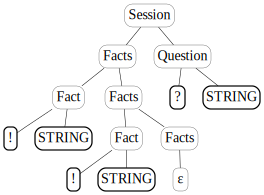

In [ ]:
ProductionGraph(d)

### Un esempio più interessante

Come esempio più "interessante" consideriamo una grammatica per espressioni aritmentiche parentesizzate.

In [ ]:
# MCD, fig. 3.4, pag. 123

G_expr = Grammar.from_string("""
input -> expression
expression -> term rest_expression
term -> IDENTIFIER | parenthesized_expression 
parenthesized_expression -> ( expression ) 
rest_expression -> + expression | ε
""")

In [ ]:
TABLEf = make_table_function(G_expr)

In [ ]:
INPUT = 'IDENTIFIER + ( IDENTIFIER )'.split()
d = full_parse(G_expr, TABLEf, INPUT)

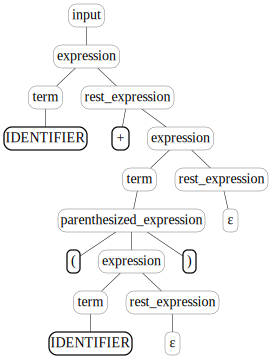

In [ ]:
ProductionGraph(d)

## L'insieme `FOLLOW`, e `TABLE` (senza `FIRSTf` e pila)

A prescindere dalla necessità di determinare se valga la proprietà *full LL(1)* (fatto che non può essere appurato con una precomputazione, ma a limite può essere segnalato  all'accadere di un conflitto, come avviene in `TABLEf`), resta comunque il problema che `TABLEf` richiede l'accesso all'intero contenuto $\Gamma$ della pila e che gli insiemi $\operatorname{FIRST}(\alpha\Gamma\#)$ non possono essere precomputati (per tutte le possibili pile).

Osserviamo che se $A\to \alpha$ e $\varepsilon \not\in \operatorname{FIRST}(\alpha)$, allora $\operatorname{FIRST}(\alpha\Gamma\#) = \operatorname{FIRST}(\alpha)$; il calcolo è quindi necessario nel caso in cui $\varepsilon \in \operatorname{FIRST}(\alpha)$ per cui invece $\operatorname{FIRST}(\alpha\Gamma\#) = \left( 
\operatorname{FIRST}(\alpha) \setminus \{\varepsilon\} \right) \cup
\operatorname{FIRST}(\Gamma\#)$.

Invece di calcolare $\operatorname{FIRST}(\Gamma\#)$ al variare del contenuto della pila $\Gamma$, si può considerare l'unione di tutti gli insiemi per ciascuna possibile pila (fermo restando il lato sinistro $A$):
$$
\operatorname{FOLLOW}(A) = 
\bigcup_{x, \Gamma : S\#\overset{*}{\to}x A\Gamma\#} \operatorname{FIRST}(\Gamma\#) = 
\{t \in T | S\#\overset{*}{\to}x A t y\#\}.
$$

Come vedremo:

* l'insieme $\operatorname{FOLLOW}(A)$ può essere precomputato (attraverso una chiusura),

* è possibile costruire una tabella di predizione usando, per ogni $A\to \alpha$, solo gli insiemi $\operatorname{FIRST}(\alpha)$ e $\operatorname{FOLLOW}(A)$.

Iniziamo dal primo punto.

In [ ]:
def compute_follow(G, FIRST):

  FOLLOW = Table(1, set)
  FOLLOW[G.S] |= {HASH}

  @closure
  def complete_follow(FOLLOW):
    for X, ω in G.P:
      for γ in suffixes(ω): # X -> α A β (α è mangiato dal suffisso)
        A, *β = γ
        if A not in G.N: continue
        FOLLOW[A] |= FIRST[β] - {ε}
        if ε in FIRST[β]: FOLLOW[A] |= FOLLOW[X]
    return FOLLOW
  
  return complete_follow(FOLLOW)

L'osservazione cruciale è che, data una produzione $X\to \omega$, per ogni fattorizzazione di $\omega$ come $\alpha A \beta$, si ha che $\operatorname{FOLLOW}(A)$ contiene:

* $\operatorname{FIRST}(\beta)$ (tolto eventualmente $\varepsilon$),
* $\operatorname{FOLLOW}(X)$ se $\varepsilon \in \operatorname{FIRST}(\beta)$.

Il secondo punto segue dal fatto che $S\#\overset{*}{\to}x X t y\to x\alpha A \beta t y\# \overset{*}{\to} x\alpha A t y\#$ quindi quel che segue $X$ segiurà anche $A$.

Facciamo un esempio con la grammatica $G$ (di "fatti e domande"):

In [ ]:
FIRST = compute_εfirst(G)
FIRST.restrict_to({(N, ) for N in G.N})

In [ ]:
FOLLOW = compute_follow(G, FIRST)
FOLLOW

Ora è possibile precomputare una vera e propria tabella, per ciascuna produzione $A\to\alpha$ tenendo traccia dei conflitti tra $\operatorname{FIRST}$ e $\operatorname{FOLLOW}$

In [ ]:
def compute_table(G, FIRST, FOLLOW):

  TABLE = Table(2)
  FIRST_TABLE = Table(2)
  FOLLOW_TABLE = Table(2)

  for P in G.P:
    A, α = P
    for a in FIRST[α] - {'ε'}:
      if FIRST_TABLE[A, a] is not None:
        warn('First/first conflict on ({}, {}) for production {}'.format(A, a, P))
      else:
        FIRST_TABLE[A, a] = P
        TABLE[A, a] = P
    if 'ε' in FIRST[α]:
      for a in FOLLOW[A]:
        if FIRST_TABLE[A, a] is not None:
          warn('First/follow conflict on ({}, {}) for production {}'.format(A, a, P))
        if FOLLOW_TABLE[A, a] is not None:
          warn('Follow/follow conflict on ({}, {}) for production {}'.format(A, a, P))
        if FIRST_TABLE[A, a] is None and FOLLOW_TABLE[A, a] is None:
          FOLLOW_TABLE[A, a] = P
          TABLE[A, a] = P
  return TABLE

Se la tabella contiene al più una produzione per ogni cella, allora la grammatica è detta **strong LL(1)**. Osservate che se una grammatica è full LL(1) allora è anche strong LL(1) (si dimostra per contronominale, vedi la Sez. 8.2.3. del libro)!

Possiamo costruire la tabella per la grammatica dell'esempio precedente

In [ ]:
TABLE = compute_table(G, FIRST, FOLLOW)
TABLE

La costruzione del parser *strong* è molto simile a quella *full* della precedente sezione, ma ora la tabella è una vera e propria tabella e basta consultarla per la coppia $(A, a)$, non c'è bisogno di guardare tutta la pila!

In [ ]:
def parse(G, TABLE, INPUT):
  tdid = TopDownInstantaneousDescription(G, INPUT)
  while not tdid.is_done():
    if tdid.top() in G.N:
      P = TABLE[tdid.top(), tdid.head()]
      if P is None:
        warn('No production for ({}, {}) at {}.'.format(tdid.top(), tdid.head(), tdid.steps) )
        return None 
      tdid = tdid.predict(P)
    else:
      if tdid.top() == ε or tdid.top() == tdid.head():
        tdid = tdid.match()
      else:
        warn('Expecting {}, got {}.'.format(tdid.top(), tdid.head()))
        return None   
  return Derivation(G).leftmost(tdid.steps)

Facciamo un esempio sulla solita grammatica

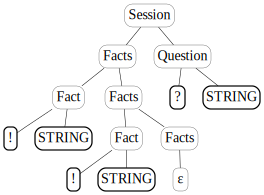

In [ ]:
d = parse(G, TABLE, '! STRING ! STRING ? STRING'.split())
ProductionGraph(d)

### Consideriamo i vari casi di conflitto attraverso degli esempi

Introduciamo una funzione di comodo che faccia i vari passi di comptuazione…

In [ ]:
def fft(G):
  FIRST = compute_εfirst(G)
  FOLLOW = compute_follow(G, FIRST)
  FF = Table(2)
  for N in G.N: 
    FF[N, 'First'] = FIRST[(N, )]
    FF[N, 'Follow'] = FOLLOW[N]
  return FF, compute_table(G, FIRST, FOLLOW)

#### Caso first/first

In [ ]:
G = Grammar.from_string("""
S -> a | A
A -> a
""")

In [ ]:
FF, TABLE = fft(G)

First/first conflict on (S, a) for production S -> A


In [ ]:
FF

In [ ]:
TABLE

#### Caso first/follow

In [ ]:
G = Grammar.from_string("""
S -> A a
A -> a | ε
""")

In [ ]:
FF, TABLE = fft(G)

First/follow conflict on (A, a) for production A -> ε


In [ ]:
FF

In [ ]:
TABLE

#### Caso follow/follow

In [ ]:
G = Grammar.from_string("""
S -> A a
A -> B | C
B -> ε | b
C -> ε | c
""")

In [ ]:
FF, TABLE = fft(G) 

Follow/follow conflict on (A, a) for production A -> C


In [ ]:
FF

In [ ]:
TABLE

## Fattorizzazione ed eliminazione dei conflitti

In presenza di due alternative $A\to \alpha\beta|\alpha\gamma$ con $\alpha$ non trasparente è evidente che sia impossibile scegliere sulla base di $\operatorname{FIRST}(\alpha)$ che riguarda entrambe le alternative! Una possibile soluzione consiste nel "fattorizzare" $\alpha$ mendiante l'introduzione di un nuovo non terminale $N$ cambiando le produzioni in $A\to \alpha N$ e $N\to \beta|\gamma$ sperando che $\operatorname{FIRST}(\beta)$ e $\operatorname{FIRST}(\gamma)$ siano disigunti.

Proviamo ad usare, come esempio, una grammatica per operazioni aritmetiche in cui ogni operatore coinvolga esattamente due sottoespressioni:

In [ ]:
G = Grammar.from_string("""
E -> T + T | T
T -> F * F | F 
F -> ( E ) | i
""")

Ci sono conflitti…

In [ ]:
FF, TABLE = fft(G) 

First/first conflict on (E, () for production E -> T
First/first conflict on (E, i) for production E -> T
First/first conflict on (T, () for production T -> F
First/first conflict on (T, i) for production T -> F


In [ ]:
FF

In [ ]:
TABLE

Che possono essere risolti fattorizzando sia `T` che `F`

In [ ]:
G = Grammar.from_string("""
E -> T E′
E′ -> + T | ε
T -> F F′
F′ -> * F | ε
F -> ( E ) | i
""")

In [ ]:
FF, TABLE = fft(G) 

In [ ]:
TABLE

Tentiamo il parse

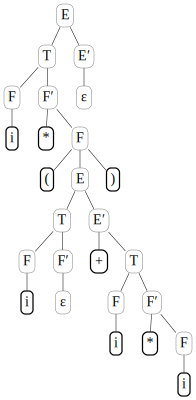

In [ ]:
ProductionGraph(parse(G, TABLE, 'i * ( i + i * i )'.split()))

La grammatica così fattorizzata si presta molto bene ad evitare la necessità di parentesizzare coppie di operandi (ma attenzione all'associatività)

In [ ]:
# aggiungo un E′ dopo T o F nelle produzioni
#
# E′ -> + T
# F′ -> * F 
#

G = Grammar.from_string("""
E -> T E′
E′ -> + T E′| ε
T -> F F′
F′ -> * F F′ | ε
F -> ( E ) | i
""")

In [ ]:
FF, TABLE = fft(G) 

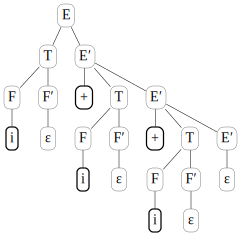

In [ ]:
ProductionGraph(parse(G, TABLE, 'i + i + i'.split()))